# Lego Ebay Project

In [54]:
import pandas as pd
import numpy as np
import sqlite3 as sql
import matplotlib.pyplot as plt
import datetime
%matplotlib inline

# **********   INJEST   **********
Create a connection to the database and save SQL queries as variables

In [2]:
# Create connection to database
database = "C:\\Users\\zubaz\\Documents\\Python\\EbayLegoWebscrape\\lego.db"
connection = sql.connect(database)

In [3]:
# 2 queries for 2 tables, one with price data, one with set metadata
query1 = '''SELECT set_num, date, price
            FROM ebay_prices'''
query2 = '''SELECT * FROM set_details'''

### Create dataframe for query1
This dataframe contains the ebay prices data

In [4]:
df = pd.read_sql_query(query1, connection)
df.head()

,set_num,date,price
0,10256,02-01-2022,20.0
1,70147,01-07-2022,158.99
2,70222,01-07-2022,119.99
3,70223,01-07-2022,184.98
4,41052,01-07-2022,185.98


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68046 entries, 0 to 68045
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   set_num  68046 non-null  object
 1   date     68046 non-null  object
 2   price    68046 non-null  object
dtypes: object(3)
memory usage: 1.6+ MB


In [6]:
# find how many unique set_num there are
num_of_sets = len(pd.unique(df['set_num']))
print(f"There is data for {num_of_sets} Lego sets")

There is data for 1710 Lego sets


### Create a dataframe for query2
This dataframe contains the set dimension data

In [7]:
df_set = pd.read_sql_query(query2, connection)
# df_set.head()

In [8]:
#change date column from text to datetime
df['date'] = pd.to_datetime(df['date'])

In [9]:
# find earliest and latest dates and how many days of data exists
oldest_date = df['date'].min()
recent_date = df['date'].max()
date_difference = recent_date - oldest_date
print(oldest_date)
print(recent_date)
print(date_difference)

2022-01-07 00:00:00
2022-02-22 00:00:00
46 days 00:00:00


# **********  EXPLORE & CLEAN  **********

## Price Dataframe
Examine the 'price' column and do some cleaning

In [10]:
# Check if all values in price column are integers
all(x.is_integer() for x in df['price'])

False

In [11]:
print(df[pd.to_numeric(df['price'], errors='coerce').isnull()])

      set_num       date            price
29      75523 2022-01-19  25.79 to 135.81
41      10235 2022-02-06     3.29 to 4.98
46      10695 2022-01-21  16.37 to 122.89
108     21316 2022-01-11    9.89 to 13.89
122     70321 2022-02-02  20.25 to 282.98
...       ...        ...              ...
67221   75827 2022-01-07         1,168.39
67475   75192 2022-02-10         1,168.83
67520   10251 2022-01-22         1,286.32
67584   21137 2022-01-22         1,749.99
67750   10251 2022-02-06         1,081.17

[506 rows x 3 columns]


In [12]:
# looks like the commas are bad, let's replace commas with nothing
df['price'] = df['price'].replace(',','', regex=True)

In [13]:
# check to see what the rest of the non numeric values look like
# print(df['price'] [pd.to_numeric(df['price'], errors='coerce').isnull()])

In [14]:
df.shape

(68046, 3)

In [15]:
# find the index of rows with 'to' in them
# these values are too hard to deal with, probably not representative listings
remove_rows = df[df['price'].str.contains("to") == True].index

print(remove_rows)

Int64Index([   29,    41,    46,   108,   122,  2932,  2983,  3255, 11001,
            11006, 11105, 11106, 11107, 11108, 11109, 11110, 11111, 13994,
            13995, 13996, 13997, 17027, 17981, 24990, 25001, 27313, 27421,
            30540, 33974, 34667, 36930, 39990, 42966, 47374, 49388, 49393,
            51649, 51689, 51696, 51706, 51718, 53207, 53610, 53665, 53668,
            53670, 53672, 53674, 53675, 53704, 53762, 53763, 53764, 53765,
            53766, 53767, 53768, 53769, 53770, 53771, 53772, 53777, 53778,
            53781, 53782, 53783, 53784, 53785, 53786, 53787, 53788, 53789,
            53790, 53791, 53793, 53811, 53824, 56138, 61228, 61230, 61231,
            61232, 61530, 63203],
           dtype='int64')


In [16]:
# remove these rows
df.drop(remove_rows, inplace=True)

In [17]:
df.shape

(67962, 3)

In [18]:
print(df[pd.to_numeric(df['price'], errors='coerce').isnull()])

Empty DataFrame
Columns: [set_num, date, price]
Index: []


In [19]:
# checks price column to make sure all rows are numeric
pd.to_numeric(df['price'], errors='coerce').notnull().all()

True

In [20]:
df.dtypes

set_num            object
date       datetime64[ns]
price              object
dtype: object

In [21]:
# now that all rows in price column are numeric, change column data type to numeric
# pandas will pick int64 if there are no decimals, float 64 if decimals are present, which there are
df['price'] = pd.to_numeric(df['price'])
df.dtypes

set_num            object
date       datetime64[ns]
price             float64
dtype: object

## Metadata Dataframe

In [22]:
# time to clean the set_details data
df_set.head()

,set_num,set_name,theme_group,theme,subtheme,year_released,launch_exit,pieces,minifigs,designer,msrp,age_range,packaging,availability,rating
0,60009-1,Helicopter Arrest,Modern day,City,Police,2013,None,352.0,5,Henrik Andersen,£39.99 / $49.99,5 - 12,Box,Retail - limited,✭✭✭✭✩ 3.8 52 ratings
1,60012-1,Coast Guard 4x4 & Diving Boat,Modern day,City,Coast Guard,2013,01 Jun 2013 - 31 Jul 2015,128.0,2 (2 Unique to this set),None,£9.99 / $19.99 / 12.99€,5 - 12,Box,Retail,✭✭✭✭✩ 3.8 145 ratings 4 Reviews Official Brick...
2,75975-1,Watchpoint: Gibraltar,Licensed,Overwatch,None,2019,01 Jan 2019 - 31 Jul 2020,730.0,4 (3 Unique to this set),Mark Stafford,£79.99 / $89.99 / 87.72€,9+,Box,Retail,✭✭✭✭✩ 3.9 114 ratings 1 Review Official Bricks...
3,10155-1,Maersk Line Container Ship,Model making,Creator Expert,Maersk,2010,01 Aug 2010 - 31 Jul 2011,990.0,None,None,£102.99 / $119.99,8+,Box,LEGO exclusive,✭✭✭✭✩ 4.1 28 ratings 3 Reviews
4,10210-1,Imperial Flagship,Model making,Creator Expert,Miscellaneous,2010,01 Jan 2010 - 31 Dec 2011,1664.0,9 (6 Unique to this set),Raphael Pretesacque,£142.99 / $179.99,14+,Box,Retail - limited,✭✭✭✭✭ 4.6 171 ratings 16 Reviews


In [23]:
# remove -1 from set_num
df_set['set_num'] = df_set['set_num'].str.split('-', n=1).str[0]

In [24]:
# split launch_exit column into 2 columns
df_set[['launch_date', 'retirement_date']] = df_set['launch_exit'].str.split(' - ', expand=True)

In [25]:
df_set.drop('launch_exit', axis=1, inplace=True)

In [26]:
# need to plit the minifigs column into total and unique
df_set[['minifigs_total', 'minifigs_unique']] = df_set['minifigs'].str.split(' ', n=1, expand=True)

In [27]:
# parse the minifig value from minifigs_unique
df_set['minifigs_unique'] = df_set['minifigs_unique'].str.split(' ', n=1).str[0].str.replace('(', '', regex=True)

In [28]:
df_set.drop('minifigs', axis=1, inplace=True)

In [29]:
# parse rating column to get the text after the stars, this grabs non numeric values for rows with no rating
df_set['rating'] = df_set['rating'].str.split(' ', n=2).str[1].str.strip()

In [30]:
# a good way to replace non-numeric rows is to_numeric method, must use coerce to force NaN values for non-numerics
df_set['rating'] = pd.to_numeric(df_set['rating'], errors='coerce')

In [31]:
# change launch retirement date columns to date
# first need to remove spaces
df_set['launch_date'] = df_set['launch_date'].str.replace(' ', '')
df_set['launch_date'] = pd.to_datetime(df_set['launch_date'], format='%d%b%Y', errors='coerce')

In [32]:
# had some t.b.a text for some rows, they threw an error, added errors=coerce and seemed to fix it
df_set['retirement_date'] = df_set['retirement_date'].str.replace(' ', '')
df_set['retirement_date'] = pd.to_datetime(df_set['retirement_date'], format='%d%b%Y', errors='coerce')

In [33]:
# clean up msrp column and grab USD values only - drop pounds and euro values if present
# use regex to extract everything after the $, the dot, and the remaining digits
# REGEX sucks. But remember to use regex101.com, it's a life saver
df_set['msrp'] = df_set['msrp'].str.extract(r"\$(\d+\.\d+)")

In [34]:
# if launch_date is empty add the value from year released date column, 
df_set['launch_date'] = df_set['launch_date'].fillna(df_set['year_released'])
# very cool, it added jan 1 to the year automatically.

In [35]:
# change some datatypes
df_set['year_released'] = df_set['year_released'].astype(int)
df_set['msrp'] = df_set['msrp'].astype(float)
df_set['minifigs_total'] = df_set['minifigs_total'].astype(float)
df_set['minifigs_unique'] = df_set['minifigs_unique'].astype(float)
df_set['set_num'] = df_set['set_num'].astype(int)

In [36]:
df_set.dtypes

set_num                     int32
set_name                   object
theme_group                object
theme                      object
subtheme                   object
year_released               int32
pieces                    float64
designer                   object
msrp                      float64
age_range                  object
packaging                  object
availability               object
rating                    float64
launch_date        datetime64[ns]
retirement_date    datetime64[ns]
minifigs_total            float64
minifigs_unique           float64
dtype: object

In [37]:
# set the index to set_num, which should be unique
df_set.set_index('set_num')

,set_name,theme_group,theme,subtheme,year_released,pieces,designer,msrp,age_range,packaging,availability,rating,launch_date,retirement_date,minifigs_total,minifigs_unique
set_num,,,,,,,,,,,,,,,,
60009,Helicopter Arrest,Modern day,City,Police,2013,352.0,Henrik Andersen,49.99,5 - 12,Box,Retail - limited,3.8,2013-01-01,NaT,5.0,NaN
60012,Coast Guard 4x4 & Diving Boat,Modern day,City,Coast Guard,2013,128.0,None,19.99,5 - 12,Box,Retail,3.8,2013-06-01,2015-07-31,2.0,2.0
75975,Watchpoint: Gibraltar,Licensed,Overwatch,None,2019,730.0,Mark Stafford,89.99,9+,Box,Retail,3.9,2019-01-01,2020-07-31,4.0,3.0
10155,Maersk Line Container Ship,Model making,Creator Expert,Maersk,2010,990.0,None,119.99,8+,Box,LEGO exclusive,4.1,2010-08-01,2011-07-31,NaN,NaN
10210,Imperial Flagship,Model making,Creator Expert,Miscellaneous,2010,1664.0,Raphael Pretesacque,179.99,14+,Box,Retail - limited,4.6,2010-01-01,2011-12-31,9.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9526,Palpatine's Arrest,Licensed,Star Wars,Episode III,2012,645.0,None,89.99,9 - 14,Box,Retail,4.4,2012-08-01,2013-12-31,6.0,6.0
9585,WeDo Resource Set,Educational,Education,None,2011,326.0,None,49.95,7+,Tub,Educational,NaN,2011-01-01,NaT,NaN,NaN
9594,Green City Challenge Set,Educational,Education,Mindstorms,2011,1365.0,None,174.95,None,None,None,NaN,2011-01-01,NaT,1.0,1.0


In [38]:
# check for all unique rows in set_num
# is_unique method only works for a series, create that first and then check for uniqueness
set_num_series = df_set['set_num'].squeeze()
set_num_series.is_unique

True

Loop through a list of sets and calculate and remove outliers, then groupby and average daily price
Create a new data frame that we will use for the rest of the analysis that is now at a daily granularity

In [39]:
# create function to remove outliers using IQR method
def remove_outliers(dataframe):
    """
    Function to identify and remove outliers from the price column using IQR method

    Parameters:
    ----------
    dataframe : a dataframe

    Returns:
    --------
    dataframe with outliers removed

    """

    Q1 = dataframe['price'].quantile(0.25)
    Q3 = dataframe['price'].quantile(0.75)
    IQR = Q3 - Q1
    lower_lim = Q1 - 1.5*IQR
    upper_lim = Q3 + 1.5*IQR
    outliers_15_low = ( dataframe['price'] < lower_lim)
    outliers_15_high = ( dataframe['price'] > upper_lim)
    df_outliers_removed = dataframe[~(outliers_15_low | outliers_15_high)]

    return df_outliers_removed
    
    # I could add another parameter for column name to make this more generic

In [40]:
# Test list of sets to loop through
test_list = [75827, 75192, 70222, 70223]
# create an empty data frame to append each looped df to
looped_df = pd.DataFrame()
for set in test_list:
    filter = (df['set_num'] == set)
    df_filtered = df[filter]
    df_no_outliers = remove_outliers(df_filtered)
    
    # reset index fills down the set_num column, creates a full dataframe
    df_filtered_grouped = df_no_outliers.groupby(['set_num', 'date']).mean().reset_index()
    looped_df = looped_df.append(df_filtered_grouped)


In [41]:
print(looped_df)

    set_num       date        price
0     75827 2022-01-07   968.783200
1     75827 2022-01-11   906.030000
2     75827 2022-01-13   945.000000
3     75827 2022-01-14   888.590000
4     75827 2022-01-17   956.480000
5     75827 2022-01-18   799.000000
6     75827 2022-01-19   990.820000
7     75827 2022-01-21  1199.990000
8     75827 2022-01-22   875.000000
9     75827 2022-01-26   832.500000
10    75827 2022-01-28   976.920000
11    75827 2022-01-31  1078.815000
12    75827 2022-02-06   973.996667
13    75827 2022-02-12   949.000000
14    75827 2022-02-16   932.280000
15    75827 2022-02-17   848.690000
16    75827 2022-02-21   874.090000
0     75192 2022-01-07  1200.862000
1     75192 2022-01-08  1191.996667
2     75192 2022-01-09  1249.995000
3     75192 2022-01-10  1190.990000
4     75192 2022-01-11  1166.326667
5     75192 2022-01-13   961.050000
6     75192 2022-01-14   957.245000
7     75192 2022-01-17  1031.796000
8     75192 2022-01-19   725.000000
9     75192 2022-01-20   447

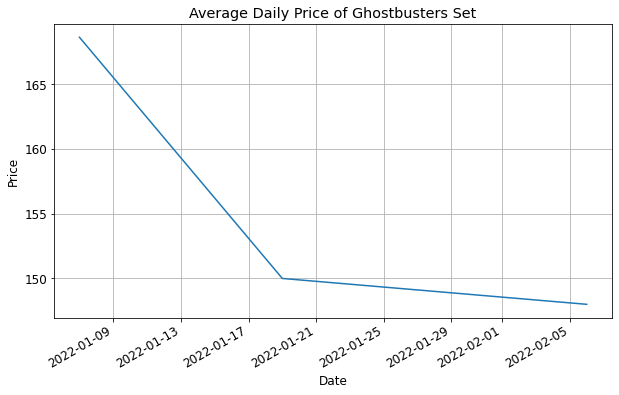

In [43]:
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(dffilt_group.index, dffilt_group.price, label='Average Daily Price')

fig.autofmt_xdate()
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.set_title('Average Daily Price of Ghostbusters Set')
ax.grid(True);

# **********  MERGE  **********

In [44]:
# check data types before the merge
df_set.dtypes

set_num                     int32
set_name                   object
theme_group                object
theme                      object
subtheme                   object
year_released               int32
pieces                    float64
designer                   object
msrp                      float64
age_range                  object
packaging                  object
availability               object
rating                    float64
launch_date        datetime64[ns]
retirement_date    datetime64[ns]
minifigs_total            float64
minifigs_unique           float64
dtype: object

In [45]:
looped_df.dtypes

set_num             int64
date       datetime64[ns]
price             float64
dtype: object

In [56]:
# I want all values in the price df and mrsp from set data
# this is a left join and we use pandas merge method
joined_df = pd.merge(looped_df,
                    df_set[['set_num', 'msrp']],
                    on = 'set_num',
                    how = 'left' 
)
joined_df.head()

,set_num,date,price,msrp
0,75827,2022-01-07,968.7832,349.99
1,75827,2022-01-11,906.0300,349.99
2,75827,2022-01-13,945.0000,349.99
3,75827,2022-01-14,888.5900,349.99
4,75827,2022-01-17,956.4800,349.99


In [57]:
# create calculated column of $ of appreciation for every row
joined_df['appreciation'] = (joined_df['price'] - joined_df['msrp']).round(2)

# create % appreciation calculated column
joined_df['pct_appreciation'] = (joined_df['appreciation'] / joined_df['msrp'] * 100).round()

joined_df.head()

,set_num,date,price,msrp,appreciation,pct_appreciation
0,75827,2022-01-07,968.7832,349.99,618.79,177.0
1,75827,2022-01-11,906.0300,349.99,556.04,159.0
2,75827,2022-01-13,945.0000,349.99,595.01,170.0
3,75827,2022-01-14,888.5900,349.99,538.60,154.0
4,75827,2022-01-17,956.4800,349.99,606.49,173.0


In [74]:
# filter all dates to last 30 days from today
today = datetime.datetime.now()
days30ago = today - pd.Timedelta(days=30)

joined_df = joined_df.loc[joined_df.date > days30ago]

In [89]:
# calculate one % appreciation for each set_num
group_df = joined_df[['set_num', 'pct_appreciation']]
group_df = group_df.groupby('set_num').mean()
group_df

,pct_appreciation
set_num,
70223,196.00
75192,25.75
75827,166.50
